# <center> Shearlet inpainting </center>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab
import time

In [3]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


- Inpainting = optimization problem.

Let $x\in\ell^2(\mathbb{Z}^2)$ be a grayscale image partially occluded by a binary mask $\mathbf{M}\in\{0,1\}^{\mathbb{Z}\times\mathbb{Z}}$, i.e.
$$
y =\mathbf{M}x
$$
One can recover $x$ (inpaint) using an sparsifying transformation with the inverse problem
$$
y^*=\min_{x\in \mathbb{R}^{N\times N}} ||S(x)||_1 \text{  s.t. } y=\mathbf{M}x
$$
By iterative thresholding algorithm
$$
x_{n+1} = S^*(T_{\lambda_n}(S(x_n+\alpha_n(y-\mathbf{M}x_n))))
$$

$\lambda_n$ decreases with the iteration number lineraly in $[\lambda_{min},\lambda_{max}]$. 

**Define paramters.**

In [4]:
sigma = 30
scales = 4
thresholdingFactor = 3

**Load data**

In [5]:
# load data
n = 512
f = load_image("./data/flowers.png",512)
f = f.astype(float)

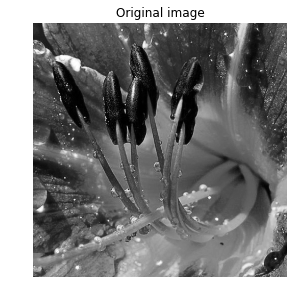

In [6]:
plt.figure(figsize=(10,10))
imageplot(f, 'Original image', [1,2,1])

**Apply the mask to the data**

In [7]:
# Import two masks
n = 512
name = "./data/mask_rand.png";
mask_rand = load_image(name, n);
name = "./data/mask_squares.png";
mask_squares = load_image(name, n);

In [8]:
fMasked_random = mask_rand*f
fMasked_squares = mask_squares*f

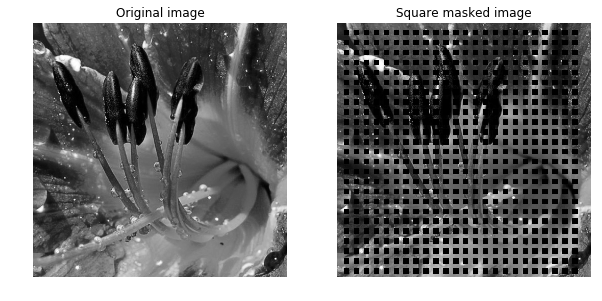

In [9]:
plt.figure(figsize=(10,10))
imageplot(f, 'Original image', [1,2,1])
imageplot(fMasked_squares, 'Square masked image', [1,2,2])

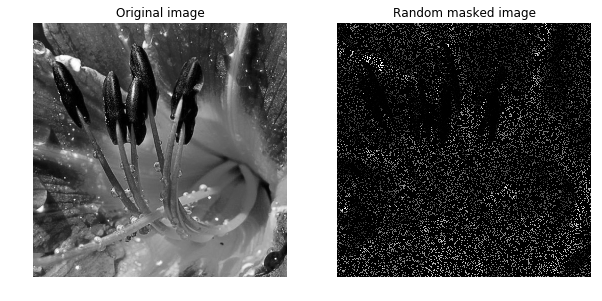

In [10]:
plt.figure(figsize=(10,10))
imageplot(f, 'Original image', [1,2,1])
imageplot(fMasked_random, 'Random masked image', [1,2,2])

**Implement iterative hard thresholding**

In [11]:
def inpaint2D(imgMasked,mask,iterations,stopFactor,shearletsystem):
    ## Compute coefficients
    coeffs = pyshearlab.SLsheardec2D(imgMasked, shearletsystem)
    ## Normalize the coefficients
    coeffsNormalized = np.zeros(coeffs.shape,complex64)     
    for i in range(shearletsystem['nShearlets']):
        coeffsNormalized[:,:,i] = coeffs[:,:,i]/shearletsystem['RMS'][i];
    ## Define the parameters
    delta = np.abs(coeffsNormalized).max();
    lamb=(stopFactor)**(1/(iterations-1));
    imgInpainted = np.zeros(imgMasked.shape);
    #iterative thresholding
    for it in range(iterations):
        res = mask*(imgMasked-imgInpainted);
        coeffs = pyshearlab.SLsheardec2D(imgInpainted+res,shearletsystem);
        coeffsNormalized = np.zeros(coeffs.shape, complex64);
        for i in range(shearletsystem['nShearlets']):
            coeffsNormalized[:,:,i] = coeffs[:,:,i]/shearletsystem['RMS'][i];
        coeffs = coeffs*(np.abs(coeffsNormalized)>delta);
        imgInpainted = pyshearlab.SLshearrec2D(coeffs,shearletsystem);  
        delta=delta*lamb; 
    return imgInpainted

**Create Shearlet System**

In [12]:
shearletSystem =  pyshearlab.SLgetShearletSystem2D(0,f.shape[0], f.shape[1], scales)

**Inpainting the random mask**

In [13]:
iterations = 50
stopFactor = 0.005

In [14]:
t = time.time()
inpainted_mask_random = inpaint2D(fMasked_random,mask_rand,iterations,stopFactor,shearletSystem)
print(time.time()-t)

219.5996959209442


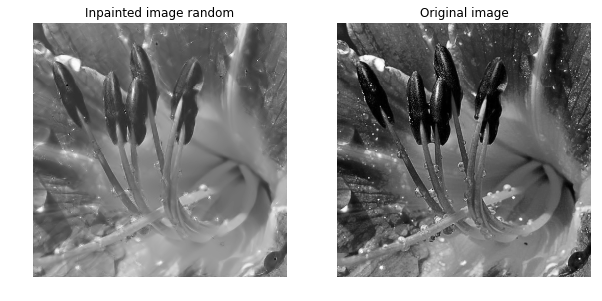

In [15]:
plt.figure(figsize=(10,10))
imageplot(inpainted_mask_random, 'Inpainted image random', [1,2,1])
imageplot(f, 'Original image', [1,2,2])

**Inpainting the random mask**

In [16]:
t = time.time()
inpainted_mask_squares = inpaint2D(fMasked_squares,mask_squares,iterations,stopFactor,shearletSystem)
print(time.time()-t)

206.119558095932


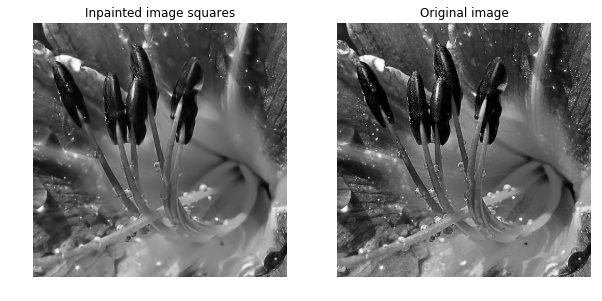

In [17]:
plt.figure(figsize=(10,10))
imageplot(inpainted_mask_squares, 'Inpainted image squares', [1,2,1])
imageplot(f, 'Original image', [1,2,2])

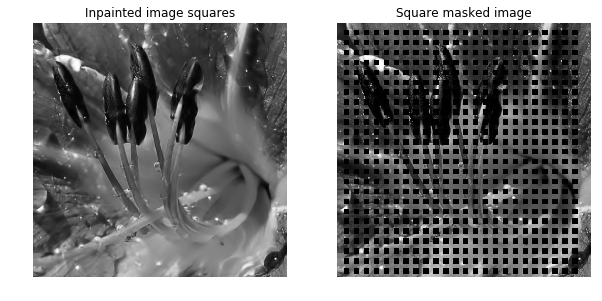

In [19]:
plt.figure(figsize=(10,10))
imageplot(inpainted_mask_squares, 'Inpainted image squares', [1,2,1])
imageplot(fMasked_squares, 'Square masked image', [1,2,2])

## Inpainting is not magic

It is very effective when the lost information cannot be recovered from local features, some real problems involve global relations.

In [21]:
# load data
n = 512
face = load_image("./data/geof.jpg",n)
face = face.astype(float)

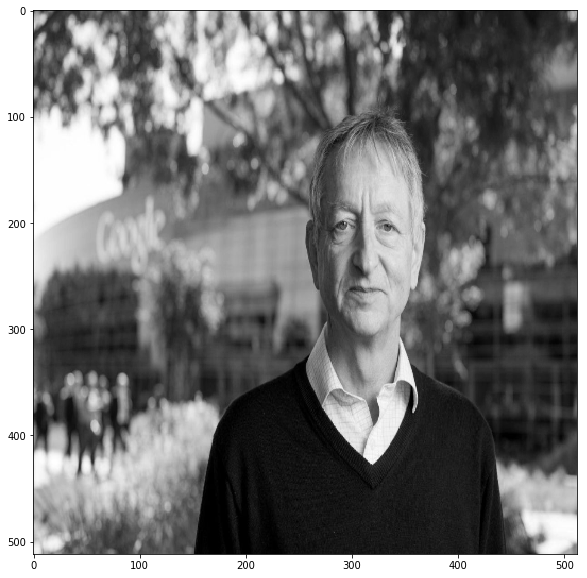

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(face, cmap = "gray")

In [81]:
mask_eye = np.ones(face.shape)

In [88]:
mask_eye[195:210,290:305] = 0

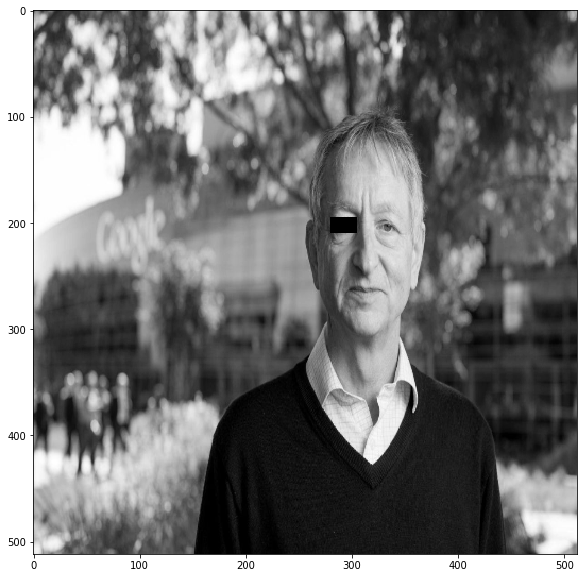

In [89]:
plt.figure(figsize=(10,10))
plt.imshow(mask_eye*face, cmap = "gray")

In [90]:
face_masked = mask_eye*face

In [100]:
t = time.time()
inpainted_face = inpaint2D(face_masked,mask_eye,150,stopFactor,shearletSystem)
print(time.time()-t)

609.5802140235901


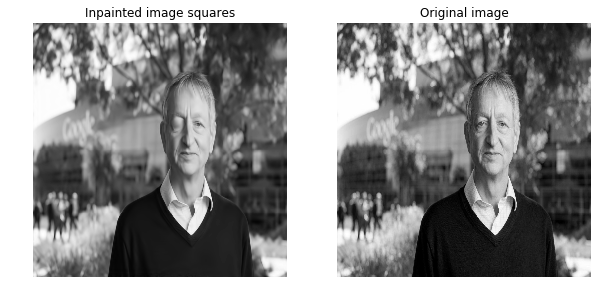

In [101]:
plt.figure(figsize=(10,10))
imageplot(inpainted_face, 'Inpainted image squares', [1,2,1])
imageplot(face, 'Original image', [1,2,2])

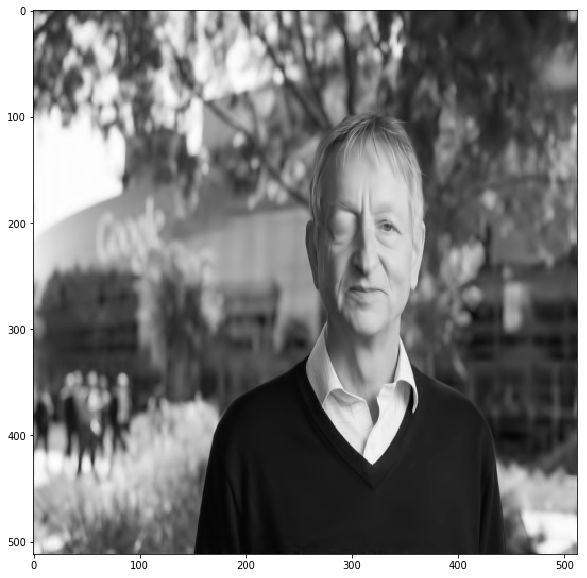

In [104]:
plt.figure(figsize=(10,10))
plt.imshow(inpainted_face, cmap = "gray")